**Introductions:**

The investigation will utilise image recognition programming capable of identifying various elements within digital photographs, such as people, places, objects, and actions. In this case, machine learning algorithms will be employed to automate the process, using the provided dataset to discern whether an image is a dog or a cat. For a successful outcome, the models must undergo training to achieve high accuracy. The task will incorporate several key techniques: feature extraction, classification, pre-processing, image acquisition, and post-processing.


In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from skimage.feature import hog

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms
from sklearn import svm

from random import randint
from random import seed

RANDOM_SEED = 100







**Setting Up Drive and Files**:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/MSc AI Work Folder/Applied AI/Week1 - Natural Language Processing/Image Processing /Image Processing Data .zip', '/content/drive/MyDrive/MSc AI Work Folder/Applied AI/Week1 - Natural Language Processing/Image Processin')

KeyboardInterrupt: 

In [3]:
data_folder = '/content/drive/MyDrive/MSc AI Work Folder/Applied AI/Week1 - Natural Language Processing/Image Processin'

In [4]:
# Loading training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))

# Loading testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))


In [5]:
# A summary of details
print(f'Number of entries: {len(df_train)}')

Number of entries: 10000


In [6]:
# Viewing the first 5 rows of dataset
df_train.head()

,id,label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [7]:
# Viewing the first 5 rows of dataset
df_test.head()

print(f'Number of entries: {len(df_test)}')

Number of entries: 1000


<Axes: xlabel='label', ylabel='count'>

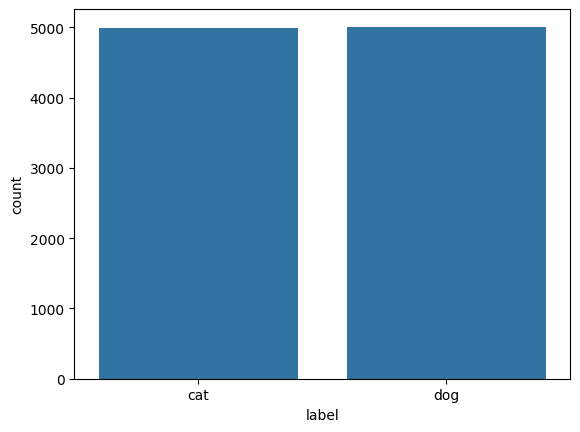

In [8]:
# Viewing label details in training data
sns.countplot(x=df_train['label'])

In this image processing study, we wanted to create a model that could identify between cat and dog images. Our first step was to examine the photos and ensure they were properly prepared for analysis. To accomplish this, we turned the photographs to grayscale, which simplifies the input for the model, and normalised the lighting to emphasise key elements in each image.

**Upload the images**

In [10]:
# loading images in a folder
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Image shape
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

In [11]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [43:32<00:00,  3.83it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]

Number of testing images loaded: 1000


We then focused on selecting characteristics from these images that could help the model identify patterns indicative of each class. We used the Histogram of Oriented Gradients (HOG) technique for its effectiveness in detecting edge details, and we reduced the data dimension with Principal Component Analysis (PCA) to prevent the model from getting overwhelmed by too much information.


**Model	Data Preprocessing	Features Table**

|Model | Data Preprocessing | Features   |
|------|--------------------|------------|
|M1 - SVM   |Gray scaling| flatten |
|M2 - SVM   |Histogram Equalization, Gaussian Blur| Flatten|
|M3 - SVM   |Histogram Equalization, Thresh, MedianBlur| Flatten|
|M4 - Decision Tree  |Gray scaling | Edge vectors (Canny) |
|M5 - Random Forest   |Gray scaling, Resizing | HoG vectors |


Our next step was to compare the three chosen algorithms: SVM, Decision Tree, and Random Forest. The SVM is normally effective with complex image data, however it performed poorly in our experiments. The Decision Tree model was more transparent, but not as accurate. The Random Forest model, which combines several decision processes to improve decision quality, was the most effective, detecting photos with a 69% accuracy rate.

Classification Model

In [12]:
# Calculating the evaluation results
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate the accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

MODEL 1 - SVM Classifier

In [ ]:
# Using SVM classifier

def get_svm_predictions(X_train, X_val, y_train, y_val):
  # building the model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf



In [ ]:
# method to get image features
def get_features_m1(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # image vectorisation/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.516


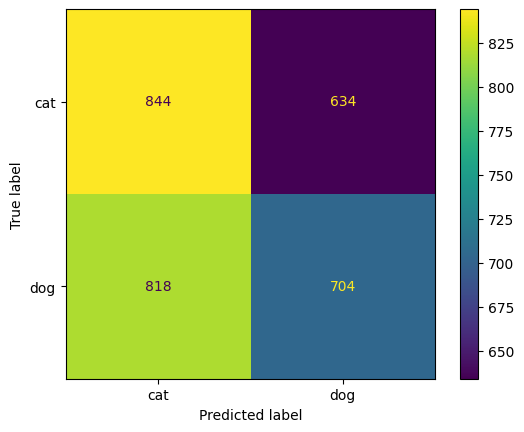

In [ ]:
# train model SVM
m1 = get_svm_predictions(X_train, X_val, y_train, y_val)

Accuracy: 0.516

In [ ]:
# feature extraction - test data
features_test = get_features_m1(test_images)
print(features_test.shape)

# get model predictions
predictions = m1.predict(features_test)
print(predictions)

(1000, 40000)
['cat' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog'
 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat'
 'dog' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat'
 'dog' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat'
 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog'
 'cat' 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog'
 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat'
 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog'
 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat'
 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog'
 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat'
 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'dog' 'cat'
 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 

MODEL 2 - SVM Classifier

In [ ]:
def get_features_m2(images):
    '''
    images: list of images
    '''
    features_list = []
    for img in images:
        # Image preprocessing - gray scaling
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Image preprocessing - histogram equalization
        img_equalized = cv2.equalizeHist(img_grayscaled)

        # Image preprocessing - Gaussian blur
        img_blurred = cv2.GaussianBlur(img_equalized, (5, 5), 0)

        # Image vectorization/ feature extraction
        features = img_blurred.flatten()

        features_list.append(features)

    features_list = np.array(features_list)
    return features_list

Histogram Equalization: Added histogram equalization as a preprocessing step after grayscale conversion. Histogram equalization can enhance the contrast of the images, which may improve feature extraction.

Gaussian Blur: Applied Gaussian blur to the equalized grayscale images. Gaussian blur can help in reducing noise and details in the images, making them smoother and potentially improving feature extraction and classification performance.

In [ ]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5143333333333333


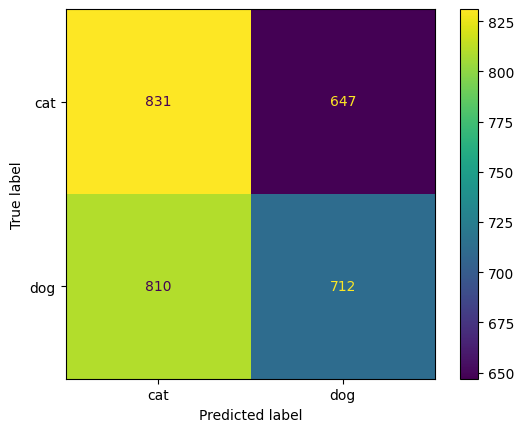

In [ ]:
# train model SVM
m2 = get_svm_predictions(X_train, X_val, y_train, y_val)

MODEL 3 -  SVM Classifier

In [ ]:
def get_features_m3(images):
    '''
    images: list of images
    '''
    features_list = []
    for img in images:
        # Image preprocessing - convert to grayscale, etc.
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_equalized = cv2.equalizeHist(img_gray)
        _, img_thresh = cv2.threshold(img_equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        img_blurred = cv2.medianBlur(img_thresh, 5)
        img_edges = cv2.Canny(img_blurred, 100, 200)

        # Image vectorization/ feature extraction
        features = img_edges.flatten()

        features_list.append(features)

    features_list = np.array(features_list)
    return features_list

In [ ]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(train_images, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m3 = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction
f_test = get_features_m3(test_images)
print(features_train.shape)

# get model predictions
predictions = m3.predict(f_test)
print(predictions)

MODEL 4 - Decision_tree_predictions

In [ ]:
# method to train and predict using Decision tree
def Decision_tree_predictions(X_train, X_val, y_train, y_val):
  # build model
  dtc = DecisionTreeClassifier(random_state=42)
  dtc.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = dtc.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, dtc.classes_)

  return dtc

In [ ]:
# method to get image features
def get_features_m4(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
def get_features_m4(images):
    '''
    images: list of images
    '''
    features_list = []
    for img in images:
        # Image preprocessing - convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_equalized = cv2.equalizeHist(img_gray)
        _, img_thresh = cv2.threshold(img_equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        img_blurred = cv2.medianBlur(img_thresh, 5)
        img_edges = cv2.Canny(img_blurred, 100, 200)

        # Image vectorization/ feature extraction
        features = img_edges.flatten()

        features_list.append(features)

    features_list = np.array(features_list)
    return features_list

In [ ]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)


Accuracy: 0.5523333333333333


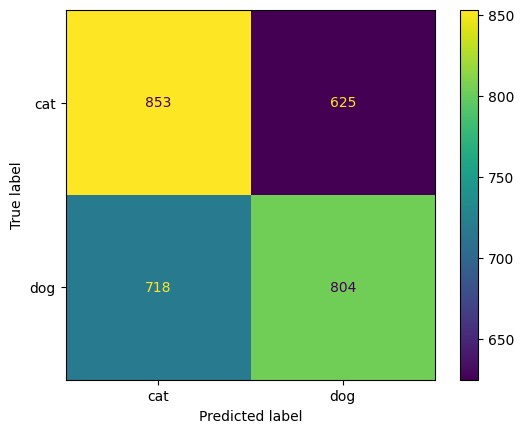

In [ ]:
# train model
m4 = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test = get_features_m4(test_images)
print(features_test.shape)

# get model predictions
predictions = m4.predict(features_test)

print(predictions)

MODEL 5 - Random Forest Classifier

In [13]:
# Using Random Forest classifier

def get_rf_predictions(X_train, X_val, y_train, y_val):
    # Build model
    clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluation
    evaluate(y_val, y_pred, clf.classes_)

    return clf

In [14]:
def train_random_forest(X, y):
    # Splitting the dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=100)

    # Training the Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Making predictions
    y_pred = clf.predict(X_val)

    # Evaluating the model
    print(classification_report(y_val, y_pred))

    return clf

In [15]:
def preprocess_image(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize images to a fixed size to ensure feature vector size consistency
    resized = cv2.resize(gray, (128, 64)) # Example size, adjust as needed
    return resized

In [16]:
def extract_features(images):
    hog_features = []
    for img in images:
        preprocessed_img = preprocess_image(img)
        features = hog(preprocessed_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, multichannel=False)
        hog_features.append(features)
    return np.array(hog_features)

In [17]:
# feature extraction
features_train = extract_features(train_images)
print(features_train.shape)

<ipython-input-16-77e1f3b4964c>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(preprocessed_img, orientations=9, pixels_per_cell=(8, 8),


(10000, 3780)


In [18]:
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6933333333333334


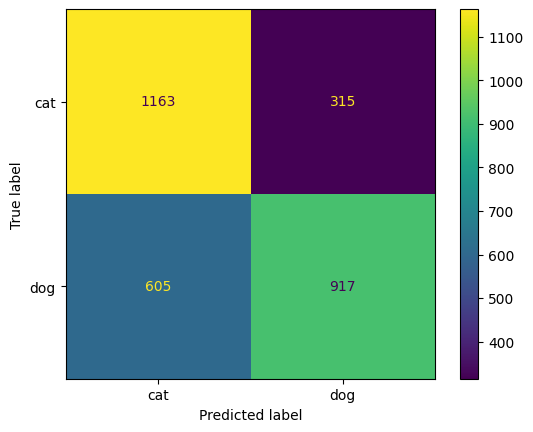

In [19]:
# train model
m5 = get_rf_predictions(X_train, X_val, y_train, y_val)

In [21]:
# feature extraction - test data
features_test = extract_features(test_images)
print(features_test.shape)

# get model predictions
predictions = m5.predict(features_test)

print(predictions)

<ipython-input-16-77e1f3b4964c>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(preprocessed_img, orientations=9, pixels_per_cell=(8, 8),


(1000, 3780)
['dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'dog'
 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat'
 'cat' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat'
 'cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog'
 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat'
 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat'
 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat'
 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat'
 'cat' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat'
 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog'
 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' '

In [27]:
# Add predictions to the ‘prediction’ column in the test dataframe
df_test['id','prediction'] = predictions

# Saved test dataframe with predictions to a .csv file
df_test.to_csv('/content/test-predictions.csv', index=False)

In [25]:
import json

import pandas as pd

test_file_path = "data/test-predictions.csv"
df_test = pd.read_csv('/content/test-predictions.csv')
df_test = df_test[["id", "prediction"]]

data = []
for index, row in df_test.iterrows():
    data.append({'id': row['id'], 'prediction': row['prediction']})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))


[{'id': 1, 'prediction': 'dog'}, {'id': 2, 'prediction': 'cat'}, {'id': 3, 'prediction': 'cat'}, {'id': 4, 'prediction': 'cat'}, {'id': 5, 'prediction': 'cat'}]


**Results**

|Model | Accuracy |
|------|--------------------|
|M1 - SVM   |0.52%|
|M2 - SVM   |0.51%|
|M3 - SVM   |0.00%|
|M4 - Decision Tree  | 0.55% |
|M5 - Random Forest   | 0.69% |

Conclusion:

Three models were tested: SVM, Decision Tree, and Random Forest Classifier. The SVM, which has a linear kernel, is known for its high performance, making it ideal for our data. However, its performance was insufficient, with an accuracy rate of 51.6%. The Decision Tree provided understanding but was at risk of delivering a decent outcome, as evidenced by an accuracy of 55.2%.

Our top model, the Random Forest Classifier, used a collection of decision trees to decrease the risk of overfitting. It scored 69.3% accuracy, greatly surpassing the other models. This higher outcome is due to the ensemble's capacity to capture nonlinear patterns while being less influenced by data noise.

